In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import pickle
import statsmodels.stats.api as sms
import numpy as np

In [68]:
mlflow.set_tracking_uri("http://localhost:5000")
results = mlflow.search_runs()

In [69]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [70]:
for c in results.columns:
    if c[:7] == 'params.':
        results = results.rename(columns={c:c[7:]})
results = results.rename(columns={'metrics.f1_val' : 'f1_val', 'metrics.f1' : 'f1'})
results.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.recall', 'metrics.accuracy', 'metrics.roc',
       'metrics.precision', 'f1', 'f1_val', 'metrics.training_precision_score',
       'metrics.training_accuracy_score', 'metrics.training_roc_auc',
       'metrics.training_log_loss', 'metrics.training_score',
       'metrics.training_f1_score', 'metrics.training_recall_score',
       'random_i', 'stage', 'model', 'n_neighbors', 'preprocessing', 'metric',
       'model_selection', 'type', 'C', 'kernel', 'n_estimators', 'algorithm',
       'min_weight_fraction_leaf', 'max_leaf_nodes', 'max_features',
       'metric_params', 'ccp_alpha', 'min_samples_leaf',
       'min_impurity_decrease', 'min_samples_split', 'max_depth', 'radius',
       'splitter', 'n_jobs', 'criterion', 'random_state', 'p', 'class_weight',
       'leaf_size', 'learning_rate', 'base_estimator', 'estimator',
       'var_smoothing', 'priors', 'shape', 'sampling_strategy', 'fe

# Experimento com treinamento e teste 80/20

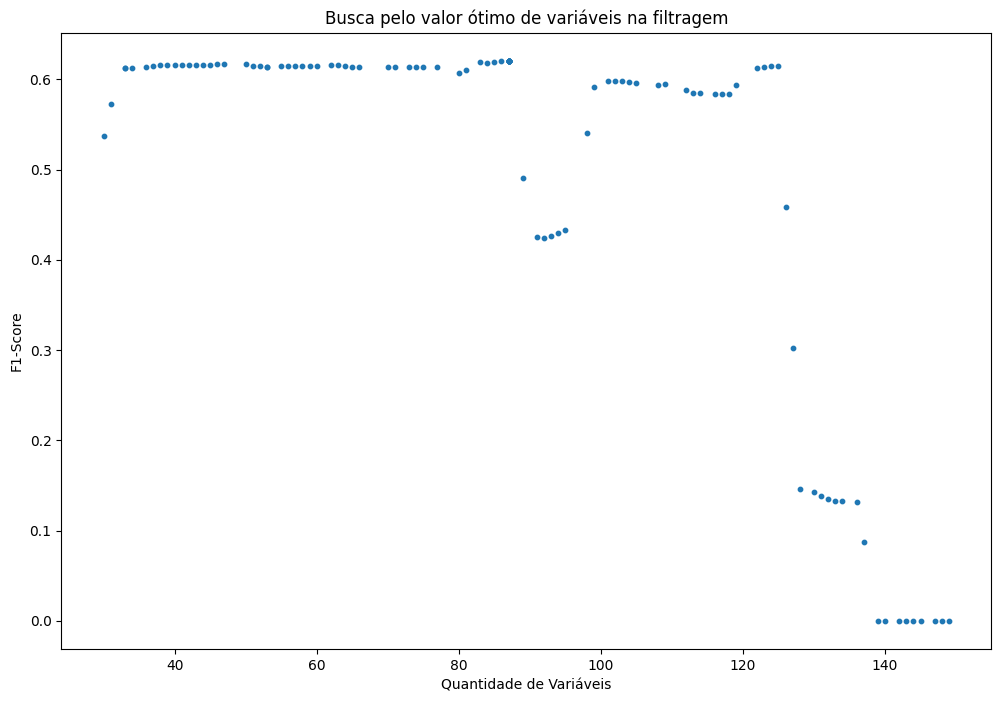

In [71]:
features_search = results[['features_i', 'f1_val', 'model_selection']].query('model_selection == "train_test"').dropna().sort_values(by='features_i', ascending=True)
features_search['features_i'] = features_search['features_i'].astype(int)
plt.scatter(features_search['features_i'], features_search['f1_val'], s=10)
plt.xlabel('Quantidade de Variáveis')
plt.ylabel('F1-Score')
plt.title('Busca pelo valor ótimo de variáveis na filtragem')
plt.show()

In [72]:
id = features_search['f1_val'].idxmax()
number_features = features_search['features_i'].loc[id]
print("O número de features encontradas é de: ", number_features)
# with open('../params/features.pkl', 'rb') as inp:
#    features = pickle.load(inp)
# print("As variáveis encontradas foram:", features)

O número de features encontradas é de:  87


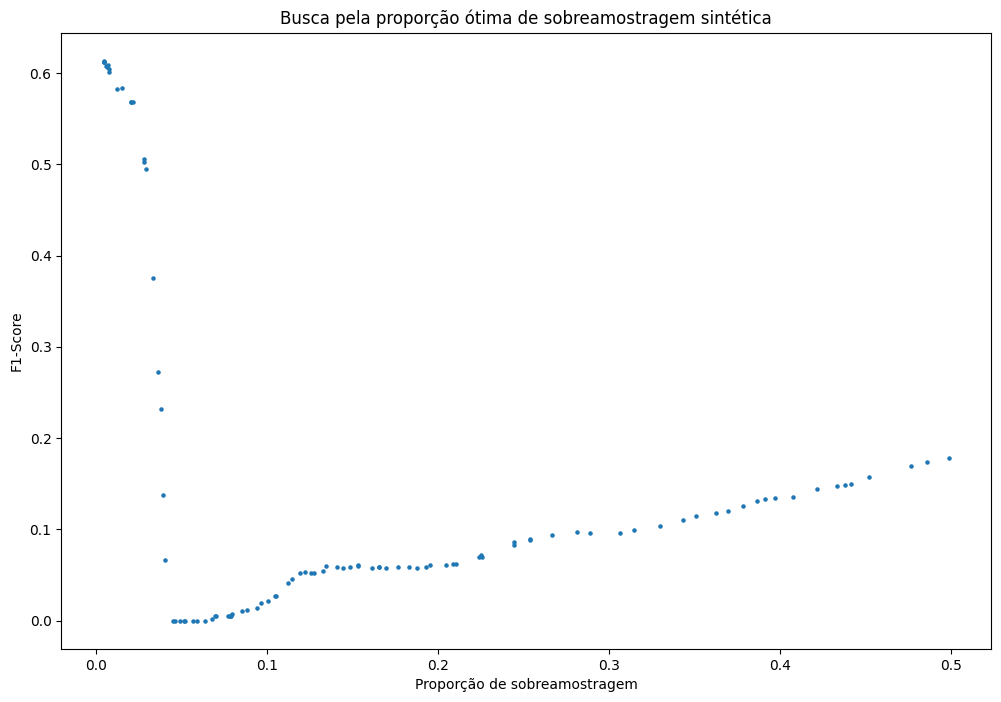

In [73]:
sampling_search = results[['sampling_strategy', 'f1_val', 'model_selection']].dropna()
sampling_search['sampling_strategy'] = sampling_search['sampling_strategy'].astype(float)
plt.scatter(sampling_search['sampling_strategy'], sampling_search['f1_val'], s=5)
plt.xlabel('Proporção de sobreamostragem')
plt.ylabel('F1-Score')
plt.title('Busca pela proporção ótima de sobreamostragem sintética')
plt.show()

In [74]:
with open('../data/params/smote.pkl', 'rb') as inp:
    var_smote = pickle.load(inp)
print("Proporção SMOTE:", var_smote)

Proporção SMOTE: 0.004664936141760721


In [75]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100

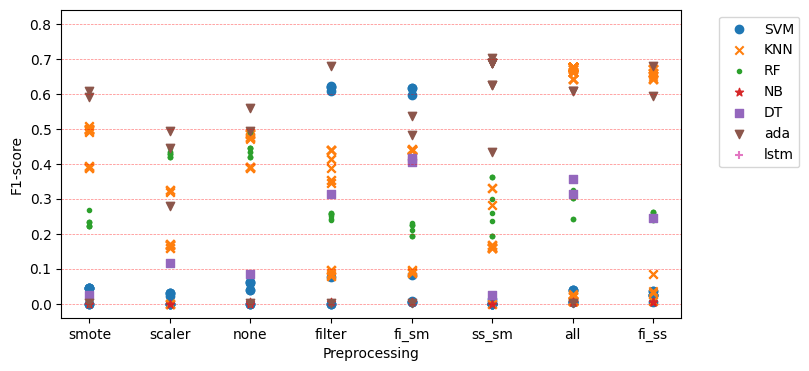

In [76]:
algo_search = results[['type', 'f1_val', 'preprocessing', 'model_selection']].query('model_selection == "train_test"').dropna()
plt.scatter(algo_search.query('type=="svm"')['preprocessing'], algo_search.query('type=="svm"')['f1_val'], marker='o', label='SVM')
plt.scatter(algo_search.query('type=="knn"')['preprocessing'], algo_search.query('type=="knn"')['f1_val'], marker='x', label='KNN')
plt.scatter(algo_search.query('type=="rf"')['preprocessing'], algo_search.query('type=="rf"')['f1_val'], marker='.', label='RF')
plt.scatter(algo_search.query('type=="nb"')['preprocessing'], algo_search.query('type=="nb"')['f1_val'], marker='*', label='NB')
plt.scatter(algo_search.query('type=="dt"')['preprocessing'], algo_search.query('type=="dt"')['f1_val'], marker='s', label='DT')
plt.scatter(algo_search.query('type=="ada"')['preprocessing'], algo_search.query('type=="ada"')['f1_val'], marker='v', label='ada')
plt.scatter(algo_search.query('type=="lstm"')['preprocessing'], algo_search.query('type=="lstm"')['f1_val'], marker='+', label='lstm') # plt.title('Comparison of Models Train/Val'), 
plt.xlabel('Preprocessing'), plt.ylabel('F1-score'), plt.legend(loc='upper center')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(y=.7, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.6, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.5, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.4, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.3, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.2, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.1, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.0, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.8, color='r', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

In [77]:
grouped = results.query('model_selection == "train_test"').groupby('type')
indices_max = grouped['f1_val'].idxmax()
best_results = {}
# Para cada modelo, imprime os parâmetros correspondentes ao melhor resultado
for modelo, indice in indices_max.items():
    parametros = results.loc[indice, ['preprocessing', 'C', 'kernel',
                                      'n_estimators', 'n_neighbors', 'criterion',
                                      'var_smoothing', 'learning_rate', 'metric']]
    parametros = {chave: valor for chave, valor in parametros.to_dict().items() if type(valor) == str}
    # print(f"{modelo}: {results.loc[indice, 'f1_val']:.2f} (parâmetros: {parametros})")
    best_results[modelo] = parametros

for result in best_results:
    if result != 'knn':
        try: 
            del best_results[result]['n_neighbors']
            del best_results[result]['metric']
        except KeyError:
            pass
best_results

{'ada': {'preprocessing': 'ss_sm', 'n_estimators': '50', 'learning_rate': '1'},
 'dt': {'preprocessing': 'fi_sm', 'criterion': 'entropy'},
 'knn': {'preprocessing': 'all', 'n_neighbors': '1', 'metric': 'manhattan'},
 'nb': {'preprocessing': 'none', 'var_smoothing': '1e-05'},
 'rf': {'preprocessing': 'none', 'n_estimators': '100'},
 'svm': {'preprocessing': 'filter', 'C': '1', 'kernel': 'rbf'}}

In [78]:
values = []
for v in features_search.index.values:
    values.append(v)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (100,) and arg 1 with shape (0,).

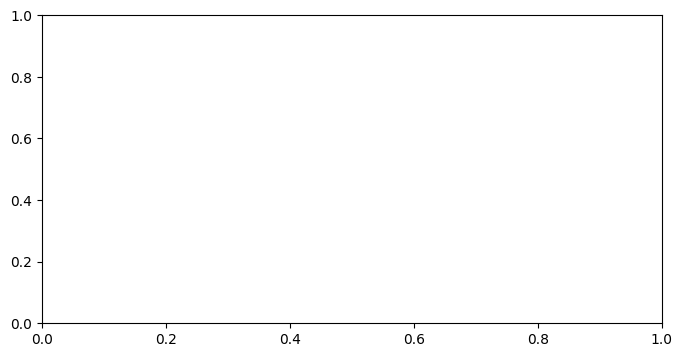

In [79]:
features_search = results[['model_selection', 'model', 'f1']].dropna().query('model_selection == "train_test"').groupby('model')['f1'].mean()
plt.bar(values, features_search.values, edgecolor='black', color='#4a95a5')
plt.xlabel('Models')
plt.ylabel('F1-Score')
g = 0
for i, v in enumerate(features_search.values):
    plt.text(i, v +.03, (str(round(v, 3)) + '±' + str(round(resultados['interval'].values[g], 3))),  fontweight='light', ha='center')
    g = g+1
plt.errorbar(values, features_search.values, resultados['interval'].values, fmt='none', ecolor='black', capsize=3)
plt.ylim(0, 1)
plt.show()

In [ ]:
features_search = results[['model_selection', 'model', 'roc']].dropna().query('model_selection == "train_test"').groupby('model')['roc'].mean()
plt.bar(features_search.index, features_search.values)
plt.xlabel('Modelos')
plt.ylabel('ROC-AUC')
plt.title('Busca pelo valor ótimo de variáveis na filtragem')
for i, v in enumerate(features_search.values):
    plt.text(i, v, str(v),  fontweight='bold', ha='center')
plt.show()

KeyError: "['roc'] not in index"

In [80]:
analise_intervalo = results.query("stage == 'statistics_analysis'")[['model', 'f1']]
models = analise_intervalo['model'].unique()
data = {'model':[], 'mean':[], 'interval':[]}
for model in models:
    query = f"model == '{model}'"
    data['model'].append(model)
    data['mean'].append(np.mean(analise_intervalo.query(query)['f1']))
    interval = sms.DescrStatsW(analise_intervalo.query(query)['f1']).tconfint_mean()
    data['interval'].append(interval[1]-interval[0])
resultados = pd.DataFrame(data)
resultados

,model,mean,interval
0,lstm,0.879195,0.010819
1,svm,0.852374,0.011851
2,rf,0.783764,0.017830
3,nb,0.033377,0.001072
4,knn,0.780082,0.017186
5,dt,0.637963,0.020887
6,ada,0.840091,0.011362


In [ ]:
def eval_one_variance(test, model, key):
    results = []
    for i in range(10):
        with mlflow.start_run(nested=True):
            mlflow.log_param("model", key)
            mlflow.log_param("stage", "statistics_analysis")
            mlflow.log_param("random_i", i)
            mlflow.tensorflow.autolog()

            # test_shuffle = test.sample(frac=0.5, random_state=i)

            # x_test = test_shuffle.drop(["INDISPONIBILIDADE"], axis=1)
            # y_test = test_shuffle[["INDISPONIBILIDADE"]]
            
            x_test = test.drop(["INDISPONIBILIDADE"], axis=1)
            y_test = test[["INDISPONIBILIDADE"]]
            y_test = y_test[4:].values

            
            add = int(len(x_test)/20)
            y = -add
            l = int(len(x_test) / 2)
            # create a for that get 50% of data plus 5% at each iteration
            for i in range(10):
                y = y + add
                n = l + y
                x_test_copy = x_test[:n].copy()
                y_test_copy = y_test[:n].copy()

            pred = predict_keras(model, x_test_copy, 5)
            
            
            # details(pred)
            f1, roc, rec, pre, acc = eval_metrics(y_test_copy, pred)
            results.append(f1)

            mlflow.log_metric("f1", f1)
            mlflow.log_metric("roc", roc)
            mlflow.log_metric("recall", rec)
            mlflow.log_metric("precision", pre)
            mlflow.log_metric("accuracy", acc)

    media = np.mean(results)
    dp = np.std(results, ddof=1)
    ci = sms.DescrStatsW(results).tconfint_mean()
    return media, dp, ci


Fold 0:
  Train: index=[0 1 2 3 4 5 6 7 8 9]
  Test:  index=[10]
Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10]
  Test:  index=[11]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11]
  Test:  index=[12]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Test:  index=[13]
Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Test:  index=[14]
Fold 5:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
  Test:  index=[15]
Fold 6:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  Test:  index=[16]
Fold 7:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
  Test:  index=[17]
Fold 8:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
  Test:  index=[18]
Fold 9:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
  Test:  index=[19]
